#### LLM directly predicts the risk classification (low, medium, high)

Choose Medgemma (it has the best effect before)

In [ ]:
import ast 
import torch._dynamo
torch._dynamo.config.suppress_errors = True


def format_features_for_prompt(features_str):
    """
    Convert the list of features in string form to natural language form.
    Input: "[('Triage RespiratoryRate', '30.0 rpm'), ('Triage SBP', '217.0 mmHg'), ...]" "
    Output: "Triage Respiratory Rate: 30.0 rpm; Triage Systolic Blood Pressure: 217.0 mmHg;" ..."
    """
    try:
        features_list = ast.literal_eval(features_str)
        return "; ".join([f"{k}: {v}" for k, v in features_list])
    except Exception as e:
        print("Feature analysis failed:", e)
        return ""


def get_risk_and_reason(response):
    """
    extract risk level and reason from LLM response
    """
    response_clean = response.strip().lower().replace("\n", " ")

    for level in ["low:", "medium:", "high:"]:
        if response_clean.startswith(level):
            reason = response_clean[len(level):].strip()
            return level[:-1], reason

    
    for level in ["low", "medium", "high"]:
        if response_clean.startswith(level):
            reason = response_clean[len(level):].strip(": ").strip()
            return level, reason

    return "uncertain", "Unable to parse risk level."


def evaluate_risk_level_with_llm(Feature_Values, llm, tokenizer):
    """
    Use LLM to directly assess the risk level of patient's death (low, medium, high)
    Input: Only the patient's clinical characteristics
    Output: risk_level, reason
    """
    
    prompt_template_en = f"""
        You are an expert clinician in emergency and critical care medicine.
        Your task is to evaluate the patient's overall in-hospital mortality risk level based on the provided clinical features.

        The patient has the following clinical characteristics:
        {Feature_Values}

        Classify the patient's in-hospital mortality risk into **exactly one** of the following levels:
        - low: the patient is at minimal risk and can be reasonably considered safe, no immediate interventions required.
        - medium: the patient's condition is complex or uncertain; further clinical assessment and monitoring are needed.
        - high: the patient is at significant risk and requires urgent attention or risk alert.

        **Important instructions**:
        1. Respond in a single line only, without extra text.
        2. Start the response with the risk level exactly as `low:`, `medium:`, or `high:`.
        3. Follow the risk level immediately by a brief clinical justification (1-2 sentences), no line breaks.
        4. Do not include quotes, explanations, or anything else.

        Example response format:
        low: The patient has normal vitals and no organ dysfunction, indicating minimal risk.
        medium: The patient has moderate hypotension and elevated lactate, requiring further monitoring.
        high: The patient is hypotensive with altered mental status, indicating urgent risk.
        """

    messages = [
        {"role": "system", "content": "You are a clinical assistant specialized in ED mortality early warning."},
        {"role": "user", "content": prompt_template_en}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    model_inputs = tokenizer([text], return_tensors="pt").to(llm.device)

    generated_ids = llm.generate(
        **model_inputs,
        max_new_tokens=200,
        temperature=0.1,
    )

    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(
        model_inputs.input_ids, generated_ids
    )]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    risk, reason = get_risk_and_reason(response)
    return risk, reason


/home/mailiyi/.conda/envs/llm_ft_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
import pandas as pd
import numpy as np

db = 'SZBA_Ext'  # example database name

cd = './LLM_Risk_Stratification/'
file_path = cd + 'LLM_input_data/' + db + '/' + 'llm_input_data.csv'  ## 预测概率+风险等级+患者Top20特征(个性SHAP排序)及对应值(特征原始值)

## Select high-risk patients
feature_values = pd.read_csv(file_path)


In [3]:
feature_values

,stay_id,y_test,y_tepred,Feature_Values,risk_level
0,19676868,0,0.000812,"[('Age', '32 year'), ('Triage Diastolic Blood ...",low-risk
1,20019539,0,0.000235,"[('Lactate dehydrogenase', '157.6 U/L'), ('Age...",low-risk
2,19849876,0,0.976265,"[('Emergency Department Length of Stay', '1603...",high-risk
3,19983179,0,0.017703,"[('Age', '82 year'), ('Lactate dehydrogenase',...",low-risk
4,20556845,0,0.000200,"[('Lactate dehydrogenase', '146.1 U/L'), ('Lym...",low-risk
...,...,...,...,...,...
1718,20150432,0,0.003847,"[('Emergency Department Length of Stay', '195....",low-risk
1719,20586024,0,0.000244,"[('Lactate dehydrogenase', '208.0 U/L'), ('Lym...",low-risk
1720,19729928,0,0.892587,"[('is Neoplasms_ICD-10 codes C00–D49', '1.0'),...",high-risk
1721,20053783,0,0.233384,"[('is Neoplasms_ICD-10 codes C00–D49', '1.0'),...",medium-risk


In [ ]:
### load LLM model
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
torch.set_float32_matmul_precision('high')  # or 'medium' 

model_id = "./download_llms/medgemma-27b-text-it"

llm = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Loading checkpoint shards: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


In [5]:
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"

In [ ]:
## test on a single patient
patient_idx = 0

patient_id = feature_values.iloc[patient_idx]['stay_id']
feature_list = feature_values.iloc[patient_idx]['Feature_Values']  


decision, reason = evaluate_risk_level_with_llm( feature_list, llm, tokenizer)
print(f"Decision: {decision}")
print(f"Reason: {reason}")

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Decision: low
Reason: the patient is young with stable vital signs and moderate triage acuity, suggesting minimal immediate mortality risk.


In [ ]:
### run on top 3 high-risk patients ###

import pandas as pd
import os
from tqdm import tqdm  

# save path
save_path = cd + 'llm_classify_ext/medgemma/' + db + '/'
if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))

# define function to process each patient
def process_patient(i):
    patient_row = feature_values.iloc[i]

    patient_id = patient_row['stay_id']
    risk_level = patient_row['risk_level']
    feature_list = patient_row['Feature_Values']
    # predicted_risk = round(patient_row['y_tepred'] * 100, 2)
    y_test = patient_row['y_test']

    decision, reason = evaluate_risk_level_with_llm( feature_list, llm, tokenizer)

    return {
        'stay_id': patient_id,
        'y_test': y_test,
        'risk_level_ml': risk_level,
        'LLM_decision_llm': decision,
        'LLM_reason_llm': reason
    }

# use for loop to process top 3 high-risk patients, store results
results = []
for i in tqdm(range(3)):
    res = process_patient(i)
    results.append(res)


# 转为 DataFrame
llm_results_df = pd.DataFrame(results)

# 保存CSV文件
llm_results_df.to_csv(save_path + 'llm_risk_level_classify.csv', index=False)



100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


In [ ]:
### run on all high-risk patients ###

import pandas as pd
import os
from tqdm import tqdm

# save path
save_path = cd + 'llm_classify_ext/medgemma/' + db + '/'
if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))

# single patient processing function (reuse)
def process_patient(i):
    patient_row = feature_values.iloc[i]

    patient_id = patient_row['stay_id']
    risk_level = patient_row['risk_level']
    feature_list = patient_row['Feature_Values']
    y_test = patient_row['y_test']

    decision, reason = evaluate_risk_level_with_llm(feature_list, llm, tokenizer)

    return {
        'stay_id': patient_id,
        'y_test': y_test,
        'risk_level_ml': risk_level,
        'LLM_decision_llm': decision,
        'LLM_reason_llm': reason
    }

# use for loop to process all patients, store results
results = []
for i in tqdm(range(len(feature_values))):
    res = process_patient(i)
    results.append(res)

    # Print progress every 10 patients
    if (i + 1) % 10 == 0:
        print(f"Processed {i+1} patients...")

# DataFrame
llm_results_df = pd.DataFrame(results)

# CSV
llm_results_df.to_csv(save_path + 'llm_risk_level_classify.csv', index=False)
print("All done. Saved.")


  1%|          | 10/1723 [00:58<3:06:53,  6.55s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 10 patients...


  1%|          | 20/1723 [01:44<2:06:27,  4.46s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 20 patients...


  2%|▏         | 30/1723 [02:33<2:06:10,  4.47s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 30 patients...


  2%|▏         | 40/1723 [03:13<1:51:50,  3.99s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 40 patients...


  3%|▎         | 50/1723 [03:53<1:48:57,  3.91s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 50 patients...


  3%|▎         | 60/1723 [04:48<2:10:00,  4.69s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 60 patients...


  4%|▍         | 70/1723 [05:44<2:18:31,  5.03s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 70 patients...


  5%|▍         | 80/1723 [06:32<2:22:12,  5.19s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 80 patients...


  5%|▌         | 90/1723 [07:17<2:02:35,  4.50s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 90 patients...


  6%|▌         | 100/1723 [08:06<2:14:33,  4.97s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 100 patients...


  6%|▋         | 110/1723 [08:50<1:47:05,  3.98s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 110 patients...


  7%|▋         | 120/1723 [09:40<2:13:19,  4.99s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 120 patients...


  8%|▊         | 130/1723 [10:30<2:07:25,  4.80s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 130 patients...


  8%|▊         | 140/1723 [11:19<2:18:01,  5.23s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 140 patients...


  9%|▊         | 150/1723 [12:11<2:12:53,  5.07s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 150 patients...


  9%|▉         | 160/1723 [13:00<2:08:54,  4.95s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 160 patients...


 10%|▉         | 170/1723 [14:03<2:29:59,  5.80s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 170 patients...


 10%|█         | 180/1723 [14:49<1:57:30,  4.57s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 180 patients...


 11%|█         | 190/1723 [15:37<2:04:24,  4.87s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 190 patients...


 12%|█▏        | 200/1723 [16:32<2:23:39,  5.66s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 200 patients...


 12%|█▏        | 210/1723 [17:23<1:52:03,  4.44s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 210 patients...


 13%|█▎        | 220/1723 [18:12<1:54:04,  4.55s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 220 patients...


 13%|█▎        | 230/1723 [19:01<1:49:48,  4.41s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 230 patients...


 14%|█▍        | 240/1723 [19:48<2:04:28,  5.04s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 240 patients...


 15%|█▍        | 250/1723 [20:37<2:03:56,  5.05s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 250 patients...


 15%|█▌        | 260/1723 [21:34<2:33:40,  6.30s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 260 patients...


 16%|█▌        | 270/1723 [22:18<1:40:11,  4.14s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 270 patients...


 16%|█▋        | 280/1723 [22:59<1:33:59,  3.91s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 280 patients...


 17%|█▋        | 290/1723 [23:54<2:16:56,  5.73s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 290 patients...


 17%|█▋        | 300/1723 [24:40<1:50:37,  4.66s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 300 patients...


 18%|█▊        | 310/1723 [25:29<2:24:08,  6.12s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 310 patients...


 19%|█▊        | 320/1723 [26:13<1:37:12,  4.16s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 320 patients...


 19%|█▉        | 330/1723 [27:19<2:38:13,  6.81s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 330 patients...


 20%|█▉        | 340/1723 [28:11<2:16:46,  5.93s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 340 patients...


 20%|██        | 350/1723 [29:03<2:08:03,  5.60s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 350 patients...


 21%|██        | 360/1723 [29:52<2:12:26,  5.83s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 360 patients...


 21%|██▏       | 370/1723 [30:43<2:03:39,  5.48s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 370 patients...


 22%|██▏       | 380/1723 [31:30<1:56:23,  5.20s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 380 patients...


 23%|██▎       | 390/1723 [32:16<1:40:12,  4.51s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 390 patients...


 23%|██▎       | 400/1723 [33:02<1:41:56,  4.62s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 400 patients...


 24%|██▍       | 410/1723 [33:42<1:26:05,  3.93s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 410 patients...


 24%|██▍       | 420/1723 [34:34<1:52:18,  5.17s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 420 patients...


 25%|██▍       | 430/1723 [35:28<1:46:47,  4.96s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 430 patients...


 26%|██▌       | 440/1723 [36:22<2:02:26,  5.73s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 440 patients...


 26%|██▌       | 450/1723 [37:12<2:05:55,  5.93s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 450 patients...


 27%|██▋       | 460/1723 [38:01<1:51:49,  5.31s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 460 patients...


 27%|██▋       | 470/1723 [38:50<1:52:30,  5.39s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 470 patients...


 28%|██▊       | 480/1723 [39:39<1:44:40,  5.05s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 480 patients...


 28%|██▊       | 490/1723 [40:26<1:37:58,  4.77s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 490 patients...


 29%|██▉       | 500/1723 [41:16<1:46:19,  5.22s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 500 patients...


 30%|██▉       | 510/1723 [42:08<1:48:57,  5.39s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 510 patients...


 30%|███       | 520/1723 [42:51<1:30:13,  4.50s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 520 patients...


 31%|███       | 530/1723 [43:44<1:54:50,  5.78s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 530 patients...


 31%|███▏      | 540/1723 [44:44<2:05:16,  6.35s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 540 patients...


 32%|███▏      | 550/1723 [45:32<1:28:21,  4.52s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 550 patients...


 33%|███▎      | 560/1723 [46:24<1:41:55,  5.26s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 560 patients...


 33%|███▎      | 570/1723 [47:02<1:13:25,  3.82s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 570 patients...


 34%|███▎      | 580/1723 [47:51<1:34:06,  4.94s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 580 patients...


 34%|███▍      | 590/1723 [48:52<1:48:50,  5.76s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 590 patients...


 35%|███▍      | 600/1723 [49:36<1:18:34,  4.20s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 600 patients...


 35%|███▌      | 610/1723 [50:30<1:51:53,  6.03s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 610 patients...


 36%|███▌      | 620/1723 [51:15<1:39:58,  5.44s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 620 patients...


 37%|███▋      | 630/1723 [52:04<1:42:25,  5.62s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 630 patients...


 37%|███▋      | 640/1723 [52:54<1:47:57,  5.98s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 640 patients...


 38%|███▊      | 650/1723 [53:46<1:28:36,  4.96s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 650 patients...


 38%|███▊      | 660/1723 [54:36<1:30:11,  5.09s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 660 patients...


 39%|███▉      | 670/1723 [55:28<1:25:38,  4.88s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 670 patients...


 39%|███▉      | 680/1723 [56:14<1:21:26,  4.68s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 680 patients...


 40%|████      | 690/1723 [57:00<1:15:45,  4.40s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 690 patients...


 41%|████      | 700/1723 [57:46<1:18:55,  4.63s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 700 patients...


 41%|████      | 710/1723 [58:36<1:17:02,  4.56s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 710 patients...


 42%|████▏     | 720/1723 [59:21<1:26:16,  5.16s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 720 patients...


 42%|████▏     | 730/1723 [1:00:08<1:27:22,  5.28s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 730 patients...


 43%|████▎     | 740/1723 [1:00:59<1:18:33,  4.79s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 740 patients...


 44%|████▎     | 750/1723 [1:01:45<1:12:54,  4.50s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 750 patients...


 44%|████▍     | 760/1723 [1:02:41<1:46:50,  6.66s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 760 patients...


 45%|████▍     | 770/1723 [1:03:26<1:05:29,  4.12s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 770 patients...


 45%|████▌     | 780/1723 [1:04:18<1:22:16,  5.24s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 780 patients...


 46%|████▌     | 790/1723 [1:05:07<1:17:28,  4.98s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 790 patients...


 46%|████▋     | 800/1723 [1:05:51<1:05:56,  4.29s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 800 patients...


 47%|████▋     | 810/1723 [1:06:36<1:18:46,  5.18s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 810 patients...


 48%|████▊     | 820/1723 [1:07:34<1:26:03,  5.72s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 820 patients...


 48%|████▊     | 830/1723 [1:08:23<1:11:39,  4.81s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 830 patients...


 49%|████▉     | 840/1723 [1:09:12<1:07:28,  4.58s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 840 patients...


 49%|████▉     | 850/1723 [1:10:05<1:19:57,  5.50s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 850 patients...


 50%|████▉     | 860/1723 [1:10:52<1:12:10,  5.02s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 860 patients...


 50%|█████     | 870/1723 [1:11:41<1:12:28,  5.10s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 870 patients...


 51%|█████     | 880/1723 [1:12:32<1:07:00,  4.77s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 880 patients...


 52%|█████▏    | 890/1723 [1:13:25<1:09:59,  5.04s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 890 patients...


 52%|█████▏    | 900/1723 [1:14:10<1:03:30,  4.63s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 900 patients...


 53%|█████▎    | 910/1723 [1:14:57<1:00:58,  4.50s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 910 patients...


 53%|█████▎    | 920/1723 [1:15:43<1:04:44,  4.84s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 920 patients...


 54%|█████▍    | 930/1723 [1:16:37<1:08:25,  5.18s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 930 patients...


 55%|█████▍    | 940/1723 [1:17:27<58:03,  4.45s/it]  Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 940 patients...


 55%|█████▌    | 950/1723 [1:18:12<57:49,  4.49s/it]  Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 950 patients...


 56%|█████▌    | 960/1723 [1:18:57<1:02:52,  4.94s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 960 patients...


 56%|█████▋    | 970/1723 [1:19:49<1:01:46,  4.92s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 970 patients...


 57%|█████▋    | 980/1723 [1:20:43<1:04:36,  5.22s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 980 patients...


 57%|█████▋    | 990/1723 [1:21:26<56:48,  4.65s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 990 patients...


 58%|█████▊    | 1000/1723 [1:22:15<1:02:47,  5.21s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1000 patients...


 59%|█████▊    | 1010/1723 [1:23:11<1:04:10,  5.40s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1010 patients...


 59%|█████▉    | 1020/1723 [1:24:03<57:49,  4.94s/it]  Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1020 patients...


 60%|█████▉    | 1030/1723 [1:24:50<55:48,  4.83s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1030 patients...


 60%|██████    | 1040/1723 [1:25:40<1:02:27,  5.49s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1040 patients...


 61%|██████    | 1050/1723 [1:26:34<1:07:23,  6.01s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1050 patients...


 62%|██████▏   | 1060/1723 [1:27:22<50:06,  4.53s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1060 patients...


 62%|██████▏   | 1070/1723 [1:28:15<50:59,  4.69s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1070 patients...


 63%|██████▎   | 1080/1723 [1:29:22<1:16:32,  7.14s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1080 patients...


 63%|██████▎   | 1090/1723 [1:30:16<1:00:42,  5.75s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1090 patients...


 64%|██████▍   | 1100/1723 [1:31:11<54:21,  5.24s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1100 patients...


 64%|██████▍   | 1110/1723 [1:31:59<50:00,  4.89s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1110 patients...


 65%|██████▌   | 1120/1723 [1:32:52<46:45,  4.65s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1120 patients...


 66%|██████▌   | 1130/1723 [1:33:44<52:31,  5.31s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1130 patients...


 66%|██████▌   | 1140/1723 [1:34:30<45:38,  4.70s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1140 patients...


 67%|██████▋   | 1150/1723 [1:35:28<56:18,  5.90s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1150 patients...


 67%|██████▋   | 1160/1723 [1:36:18<45:41,  4.87s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1160 patients...


 68%|██████▊   | 1170/1723 [1:37:02<42:39,  4.63s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1170 patients...


 68%|██████▊   | 1180/1723 [1:37:47<45:23,  5.02s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1180 patients...


 69%|██████▉   | 1190/1723 [1:38:38<44:36,  5.02s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1190 patients...


 70%|██████▉   | 1200/1723 [1:39:25<41:04,  4.71s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1200 patients...


 70%|███████   | 1210/1723 [1:40:19<44:53,  5.25s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1210 patients...


 71%|███████   | 1220/1723 [1:41:11<50:13,  5.99s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1220 patients...


 71%|███████▏  | 1230/1723 [1:42:08<49:12,  5.99s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1230 patients...


 72%|███████▏  | 1240/1723 [1:43:00<42:52,  5.33s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1240 patients...


 73%|███████▎  | 1250/1723 [1:43:48<39:29,  5.01s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1250 patients...


 73%|███████▎  | 1260/1723 [1:44:32<35:57,  4.66s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1260 patients...


 74%|███████▎  | 1270/1723 [1:45:19<35:31,  4.71s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1270 patients...


 74%|███████▍  | 1280/1723 [1:46:02<29:13,  3.96s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1280 patients...


 75%|███████▍  | 1290/1723 [1:46:58<35:43,  4.95s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1290 patients...


 75%|███████▌  | 1300/1723 [1:47:47<31:15,  4.43s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1300 patients...


 76%|███████▌  | 1310/1723 [1:48:30<29:14,  4.25s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1310 patients...


 77%|███████▋  | 1320/1723 [1:49:23<35:57,  5.35s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1320 patients...


 77%|███████▋  | 1330/1723 [1:50:12<31:48,  4.86s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1330 patients...


 78%|███████▊  | 1340/1723 [1:51:01<31:24,  4.92s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1340 patients...


 78%|███████▊  | 1350/1723 [1:51:44<25:24,  4.09s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1350 patients...


 79%|███████▉  | 1360/1723 [1:52:21<22:11,  3.67s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1360 patients...


 80%|███████▉  | 1370/1723 [1:53:15<31:30,  5.36s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1370 patients...


 80%|████████  | 1380/1723 [1:53:59<26:57,  4.72s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1380 patients...


 81%|████████  | 1390/1723 [1:54:55<29:11,  5.26s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1390 patients...


 81%|████████▏ | 1400/1723 [1:55:43<24:19,  4.52s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1400 patients...


 82%|████████▏ | 1410/1723 [1:56:40<34:26,  6.60s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1410 patients...


 82%|████████▏ | 1420/1723 [1:57:25<27:27,  5.44s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1420 patients...


 83%|████████▎ | 1430/1723 [1:58:11<21:52,  4.48s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1430 patients...


 84%|████████▎ | 1440/1723 [1:58:56<20:54,  4.43s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1440 patients...


 84%|████████▍ | 1450/1723 [1:59:39<19:32,  4.29s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1450 patients...


 85%|████████▍ | 1460/1723 [2:00:32<22:32,  5.14s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1460 patients...


 85%|████████▌ | 1470/1723 [2:01:20<19:25,  4.61s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1470 patients...


 86%|████████▌ | 1480/1723 [2:02:07<17:31,  4.33s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1480 patients...


 86%|████████▋ | 1490/1723 [2:02:58<19:02,  4.90s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1490 patients...


 87%|████████▋ | 1500/1723 [2:03:44<17:59,  4.84s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1500 patients...


 88%|████████▊ | 1510/1723 [2:04:29<19:13,  5.42s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1510 patients...


 88%|████████▊ | 1520/1723 [2:05:15<15:54,  4.70s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1520 patients...


 89%|████████▉ | 1530/1723 [2:05:59<14:37,  4.55s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1530 patients...


 89%|████████▉ | 1540/1723 [2:06:54<21:51,  7.17s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1540 patients...


 90%|████████▉ | 1550/1723 [2:07:34<11:53,  4.12s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1550 patients...


 91%|█████████ | 1560/1723 [2:08:21<13:12,  4.86s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1560 patients...


 91%|█████████ | 1570/1723 [2:09:14<13:24,  5.26s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1570 patients...


 92%|█████████▏| 1580/1723 [2:10:08<11:35,  4.87s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1580 patients...


 92%|█████████▏| 1590/1723 [2:11:01<14:37,  6.60s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1590 patients...


 93%|█████████▎| 1600/1723 [2:11:52<09:56,  4.85s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1600 patients...


 93%|█████████▎| 1610/1723 [2:12:40<08:50,  4.69s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1610 patients...


 94%|█████████▍| 1620/1723 [2:13:26<07:30,  4.37s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1620 patients...


 95%|█████████▍| 1630/1723 [2:14:13<07:29,  4.84s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1630 patients...


 95%|█████████▌| 1640/1723 [2:15:02<06:52,  4.97s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1640 patients...


 96%|█████████▌| 1650/1723 [2:15:50<05:12,  4.28s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1650 patients...


 96%|█████████▋| 1660/1723 [2:16:32<04:16,  4.07s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1660 patients...


 97%|█████████▋| 1670/1723 [2:17:24<05:05,  5.77s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1670 patients...


 98%|█████████▊| 1680/1723 [2:18:16<04:14,  5.91s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1680 patients...


 98%|█████████▊| 1690/1723 [2:19:03<02:41,  4.91s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1690 patients...


 99%|█████████▊| 1700/1723 [2:19:45<01:34,  4.10s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1700 patients...


 99%|█████████▉| 1710/1723 [2:20:30<00:54,  4.21s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1710 patients...


100%|█████████▉| 1720/1723 [2:21:24<00:15,  5.24s/it]Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Processed 1720 patients...


100%|██████████| 1723/1723 [2:21:40<00:00,  4.93s/it]

All done. Saved.


In [ ]:
### The distribution chart of the effect of directly using LLM to assess risk levels ###

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

save_path = './LLM_Risk_Stratification/llm_classify_ext/medgemma/SZBA_Ext/'
pred_result = pd.read_csv(save_path + 'llm_risk_level_classify.csv')
pred_result['LLM_decision_llm'].value_counts(dropna=False)

LLM_decision_llm
low       881
high      542
medium    300
Name: count, dtype: int64

高风险中真实分类为IHM=1： 67
高风险： 542


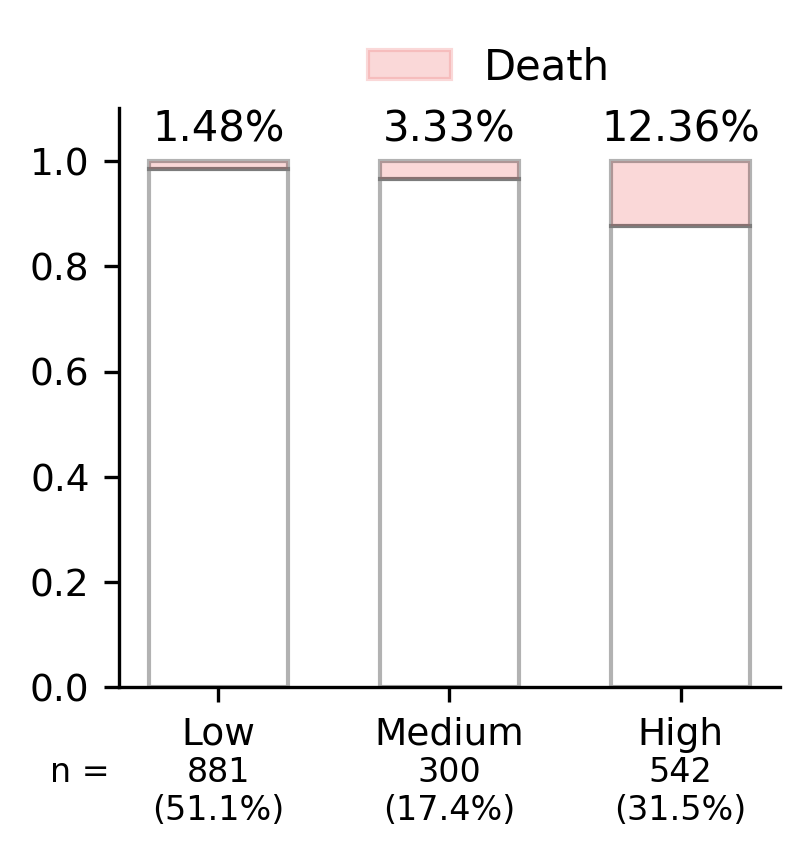

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

save_path = './LLM_Risk_Stratification/llm_classify_ext/medgemma/SZBA_Ext/'
pred_result = pd.read_csv(save_path + 'llm_risk_level_classify.csv')

## risk level categories
categories = ["Low", "Medium", "High"]  

## risk distribution
risk_1 = pred_result[pred_result['LLM_decision_llm']=='low']  
risk_2 = pred_result[pred_result['LLM_decision_llm']=='medium']  
risk_3 = pred_result[pred_result['LLM_decision_llm']=='high']  
risk_class_n = [len(risk_1), len(risk_2), len(risk_3)]

## risk proportion of true IHM=1 in each level (%)
risk_prop_1 = round(len(risk_1[risk_1['y_test'] == 1]) / len(risk_1) * 100, 2) if len(risk_1) > 0 else 0
risk_prop_2 = round(len(risk_2[risk_2['y_test'] == 1]) / len(risk_2) * 100, 2) if len(risk_2) > 0 else 0
risk_prop_3 = round(len(risk_3[risk_3['y_test'] == 1]) / len(risk_3) * 100, 2) if len(risk_3) > 0 else 0
risk_death_prop = [risk_prop_1, risk_prop_2, risk_prop_3]
print('High-risk cases classified as IHM = 1:',len(risk_3[risk_3['y_test'] == 1]))
print('High-risk:',len(risk_3))

class_prop = [round(len(risk_1) / len(pred_result) * 100, 1), round(len(risk_2) / len(pred_result) * 100, 1), round(len(risk_3) / len(pred_result) * 100, 1)]

# width of each bar
bar_width = 0.3

# position of each bar
num_bars = len(categories)  
x1 = np.linspace(0, (num_bars - 1) * 0.5, num_bars)  

fig_width = 2 + (num_bars - 2) * 0.8  
fig, ax1 = plt.subplots(figsize=(fig_width, 2.6), dpi=300)

# draw
for i, (val, n) in enumerate(zip(risk_death_prop, risk_class_n)):
   
    ax1.bar(x1[i], 100 - val, width=bar_width, color="white", edgecolor="black", alpha=0.3)
    ax1.bar(x1[i], val, bottom=100 - val, width=bar_width, color="lightcoral", edgecolor="black", alpha=0.3)
   
    ax1.text(x1[i], 102, f"{val}%", ha='center', va='bottom', fontsize=10) ##

# Y aix
ax1.set_ylim(0, 110)
ax1.set_yticks([0, 20, 40, 60, 80, 100])
ax1.set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=9)
# ax1.set_ylabel("IHM", fontsize=9)

# X aix
ax1.set_xticks(x1)
ax1.set_xticklabels(categories, fontsize=9) #


for i, n in enumerate(risk_class_n):
    ax1.text(x1[i], -13, f"{n}\n({class_prop[i]}%)", ha='center', va='top', fontsize=8) #


ax1.text(-0.3, -13, "n =", ha='center', va='top', fontsize=8) #

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# legend
death_patch = mpatches.Patch(color="lightcoral", label="Death", alpha=0.3)
fig.legend(handles=[death_patch], loc="lower center", bbox_to_anchor=(0.6, 0.92), fontsize=10, frameon=False)

# show plot
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()